# PUBG Survival Ranking Analysis
## Topics to be covered in this session
* How to become Number 1.
* What does the real game look like?
    * Looking into those tournaments
* Lets get some training going. (Covered in another Notebook)
    * We will have another type of data preprocessing scheme. It will be introduced when we start to configure ML stuffs.
    * Comparing RF, XGB, NN.
* Collecting Datas using PUBG OpenAPI.
    * Comparing our model results with the real tournament data.
    * 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/train_V2.csv")

In [3]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


### Exploring data match-wise
We discover that the data we have is really at a state of scattered dataset. We will like to first dicuss data in a match-wise sense. That is we will need to regroup the data into same matches are close together.

In [4]:
matches = df.groupby('matchId')

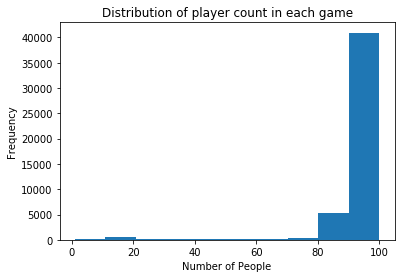

In [5]:
plt.hist(matches.size())
plt.title('Distribution of player count in each game')
plt.xlabel('Number of People')
plt.ylabel('Frequency')
plt.show()

In [6]:
len(matches)

47965

We have a total of 47965 matches. Not all of them are solos. But sure, most of them are solo games. Next we may see how what kind of games are the most popular within dataset.

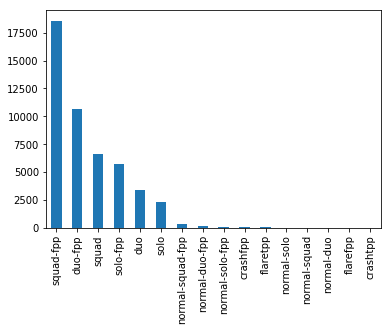

In [7]:
df.groupby('matchId')['matchType'].first().value_counts().plot.bar()

We have the following as the most popular types of games
1. squad-fpp
2. duo-fpp
3. squad
4. solo-fpp
5. duo
6. solo

The fpp on the tailing part stands for "First person perspective". That type of game restrict players to play in first-person. Whereas solo, squad, duo, doesn't force players to play in first-person. Hence, we should merge the game types into  **solo**, **duo**, and **squad**.

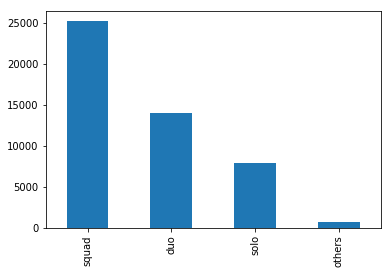

In [8]:
mapings = lambda x: 'solo' if (x == 'solo' or x == 'solo-fpp') else 'duo' if (x == 'duo') or (x == 'duo-fpp') else 'squad' if (x == 'squad') or (x == 'squad-fpp') else 'others'
df['matchType'] = df['matchType'].apply(mapings)
df.groupby('matchId')['matchType'].first().value_counts().plot.bar()

Because the first three types of game accounts over 98% of the game. We will use those games as our target of interest.

In [9]:
df = df.drop( df[df['matchType'] == 'others'].index )
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [10]:
df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,...,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411699e+06,4.411698e+06
mean,2.287636e-01,1.104919e+00,1.292689e+02,6.541450e-01,2.237317e-01,1.362065e+00,4.772881e+01,5.061995e+02,9.116071e-01,5.417493e-01,...,1.642768e-01,5.961052e+02,3.010178e-03,4.511948e+00,2.363783e-02,7.685928e-03,1.153563e+03,3.630741e+00,6.070428e+02,4.726383e-01
std,5.704108e-01,1.714651e+00,1.655583e+02,1.124138e+00,5.859880e-01,2.669458e+00,2.746011e+01,6.284095e+02,1.501082e+00,7.082327e-01,...,4.708394e-01,1.484263e+03,6.495919e-02,3.041554e+01,1.660773e-01,9.090295e-02,1.184020e+03,2.322627e+00,7.398417e+02,3.073011e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.545000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.385000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.824000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.850000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.174000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,9.700000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.977000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,1.200000e+01,3.300000e+01,3.796000e+03,3.200000e+01,2.600000e+01,8.000000e+01,1.000000e+02,2.170000e+03,3.300000e+01,1.800000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.514000e+03,4.000000e+00,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


These are the column names, of which we will pick out those involving interaction with people, and those that do not. The reason for picking out the ones with interaction is to provide a much more unified standard among different groups.

In [11]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

## SOLO
Lets first explore the pattern of winning and do some analysis upon some groups. First thing first lets
#### Preprocess the data for later on analysis
We first do match-wise preprocessing, that way datas are more consistent. 

* Converting match specific data into percentages, the features of each data can be more invariant to scale.
    * No feature scaling!!!! --> That's gooooooood!!!!

In [12]:
solo_df = df[df['matchType'] == 'solo']
solo_df = solo_df.drop('DBNOs', axis=1)
solo_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,45,0,...,0,0.0,0,0.00,0,0,49.75,2,0,0.1875
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,48,1000,...,0,2004.0,0,0.00,0,0,1089.00,6,1500,0.7368
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,0,1,324.200,1,5,5,986,...,0,1228.0,0,76.84,0,0,2050.00,6,1462,0.8750
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,0,3,254.300,0,12,13,0,...,0,2367.0,0,15.29,0,0,1787.00,3,0,0.8211
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,0,136.900,0,0,37,0,...,0,0.0,0,0.00,0,0,270.70,1,0,0.3474


We drop *DBNOs* attribute because it only happens in Squad and Duo mode.

Now we will do the following thing for all groups of matches.
* Reset winPlacePerc to rank (1,2,3,4... to maxplace)
    * Because winPlacePerc is a percentil representing the original data. For better understanding and uniform standard, we will use rank instead of percentile.
* We will divide the datas into $k$ different groups. $k\in\{3,4,5\}$
    * From there, we can later on transform a rank prediction problem into a classification problem.
* We will still look at the Winners stats.

In [13]:
matches = solo_df.groupby('matchId')
len(solo_df), len(matches)

(718705, 7976)

There is a total of 7976 games in the data.

In [14]:
solo_df['winPlacePerc'] = solo_df.groupby('matchId')['winPlacePerc'].rank(ascending=False)

In [15]:
for _,i in matches:
    print(i['winPlacePerc'].describe())
    break

count    95.000000
mean     48.000000
std      27.567615
min       1.000000
25%      24.500000
50%      48.000000
75%      71.500000
max      94.000000
Name: winPlacePerc, dtype: float64


In [16]:
solo_df = solo_df.drop(['Id', 'groupId','teamKills', 'matchType'], axis=1)

In [17]:
solo_df.head()

,matchId,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,rankPoints,revives,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4,6dc8ff871e21e6,0,0,100.000,0,0,45,0,1,1,...,1560,0,0.0,0,0.00,0,49.75,2,0,79.0
7,292611730ca862,0,0,8.538,0,0,48,1000,0,0,...,-1,0,2004.0,0,0.00,0,1089.00,6,1500,26.0
13,2c30ddf481c52d,0,1,324.200,1,5,5,986,4,1,...,-1,0,1228.0,0,76.84,0,2050.00,6,1462,13.0
17,07948d723b9c0f,0,3,254.300,0,12,13,0,2,1,...,1536,0,2367.0,0,15.29,0,1787.00,3,0,18.0
35,bc2faecb77e5ec,0,0,136.900,0,0,37,0,1,1,...,1500,0,0.0,0,0.00,0,270.70,1,0,62.0


Now we will need to pick out those features that involves interaction with people.

* killPlace is exactly ranked kills.

In [18]:
change_to_percentage = ['assists','damageDealt','headshotKills', 'heals', 'killPlace', 'killPoints','killStreaks', 'longestKill', 'rankPoints', 'revives',  'roadKills', 'vehicleDestroys', 'winPoints', 'winPlacePerc']
solo_df = solo_df.drop('kills', axis=1)
for i in solo_df.columns:
    if i in change_to_percentage:
        print(i)
        solo_df[i] = solo_df.groupby('matchId')[i].rank(axis=1)

assists
damageDealt
headshotKills
heals
killPlace
killPoints
killStreaks
longestKill
rankPoints
revives
roadKills
vehicleDestroys
winPoints
winPlacePerc


In [19]:
matches = solo_df.groupby('matchId')
for _,i in matches:
    print(i.describe())
    break

         assists     boosts  damageDealt  headshotKills      heals  killPlace  \
count  95.000000  95.000000    95.000000      95.000000  95.000000  95.000000   
mean   48.000000   1.252632    48.000000      48.000000  48.000000  48.000000   
std     8.350691   1.884813    27.028354      19.194553  24.176215  27.568098   
min    46.500000   0.000000    16.500000      38.500000  29.500000   1.000000   
25%    46.500000   0.000000    16.500000      38.500000  29.500000  24.500000   
50%    46.500000   0.000000    48.000000      38.500000  29.500000  48.000000   
75%    46.500000   2.000000    71.500000      38.500000  70.000000  71.500000   
max    94.000000   7.000000    95.000000      95.000000  95.000000  95.000000   

       killPoints  killStreaks  longestKill  matchDuration  ...  rankPoints  \
count        95.0    95.000000    95.000000           95.0  ...   95.000000   
mean         48.0    48.000000    48.000000         1949.0  ...   48.000000   
std           0.0    23.903062   

From the above checking table, the columns we have selected are converted into a **at most** kind of value. These values can now be more easily compared among different matches.

### Distributing into their buckets
After we have done the preprocessing for each match, we will now divide the players into 10 classes. Each of it having 10 players at most. Only class No$:10$ can have players$\leq10$.

In [20]:
k = 5
rank_thresh = [20 ,40 ,60 ,80]

g = [[] for i in range(k)]

print(solo_df[solo_df['winPlacePerc'].isnull()].index)
## Drop row number 2744604

solo_df = solo_df.dropna(subset=['winPlacePerc'])

cnt = 0
for i in solo_df.values:
    r = i[-1]
    cnt += 1
    g[int((r-1)/20)].append(i)
    

Int64Index([2744604], dtype='int64')


In [21]:
ans = 0
for i in range(len(g)):
    print(len(g[i]))
    ans += len(g[i])
print(ans)

158202
150421
149414
148246
112421
718704


In [22]:
for i in range(k):
    for j in range(len(g[i])):
        g[i][j] = g[i][j][1:]

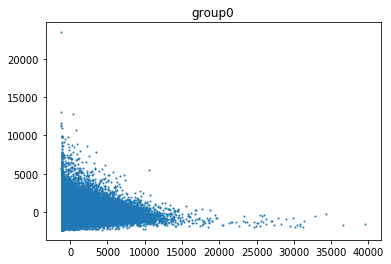

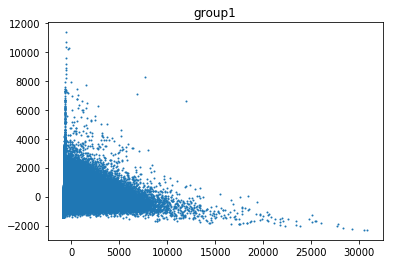

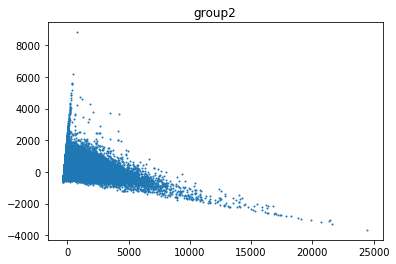

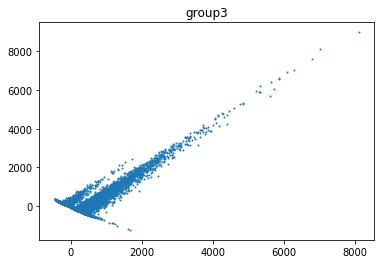

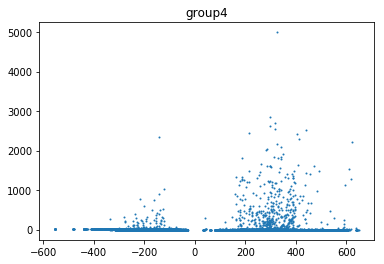

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
g_pca = g
for i in range(k):
    g_pca[i] = pca.fit_transform(g[i])
    x = []
    y = []
    for j in g_pca[i]:
        x.append(j[0])
        y.append(j[1])
    plt.scatter(x,y, s = 1)
    plt.title('group'+str(i))
    plt.show()


The above 4 buckets doesn't seems to perform well. We will use a 10 bucket strategy of classification.

718704
0 0 1
1 1 0
2 1 1
3 2 0
4 2 1
5 3 0
6 3 1
7 4 0
8 4 1
9 5 0


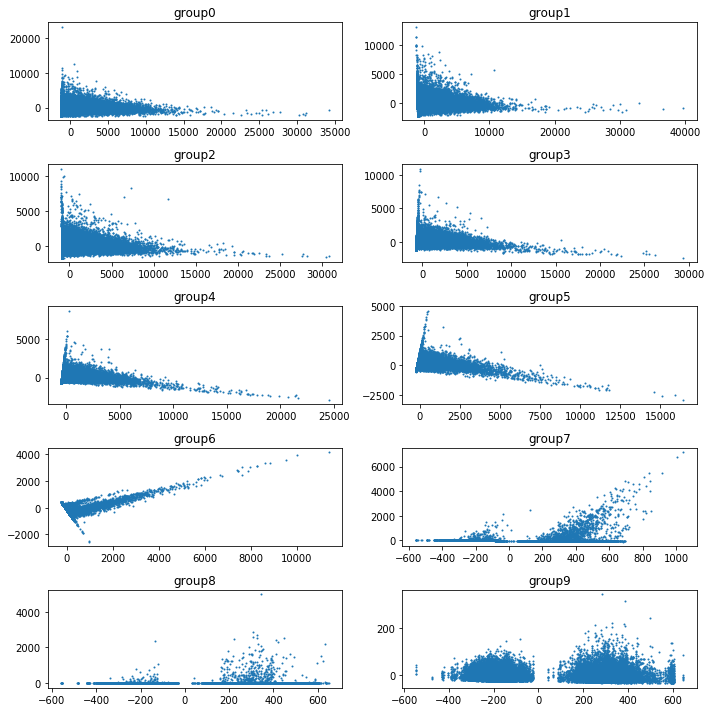

In [24]:
k = 10
rank_thresh = [10, 20, 30, 40, 50, 60, 70, 80, 90]

g = [[] for i in range(k)]

for i in solo_df.values:
    r = i[-1]
    g[int((r-1)/10)].append(i)

ans = 0
for i in range(len(g)):
#     print(len(g[i]))
    ans += len(g[i])
print(ans)

for i in range(k):
    for j in range(len(g[i])):
        g[i][j] = g[i][j][1:]

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10))
cnt_x = 0
cnt_y = 0
pca = PCA(n_components=2)
g_pca_10 = g
for i in range(k):
    print(i, end=' ')
    g_pca_10[i] = pca.fit_transform(g[i])
    x = []
    y = []
    for j in g_pca_10[i]:
        x.append(j[0])
        y.append(j[1])
    ax[cnt_x,cnt_y].scatter(x,y, s = 1)
    ax[cnt_x,cnt_y].set_title('group'+str(i))
#     ax[cnt_x,cnt_y].show
    cnt_y += 1
    if cnt_y == 2:
        cnt_x += 1
        cnt_y = 0
    print(cnt_x, cnt_y)
fig.tight_layout()
plt.show()

Now that we have different tiering strategy (distributing players into 5 groups / 10 groups). We might ask some questions a step further.

##### **In 10 Bucket Scheme**
* Why there seems to be 2 groups in group 7,8,9. Most noticibly group 9.

##### **In 5 Bucket Scheme**
* Why the same happens for group4 and 3

#### Second thoughts
* Previously, I didn't include features such as "ride Distance" "walk Distance" "maxPlace" into the percentage preprocessing stage. Will it make a difference?
* What about using percentage (percentile) instead of ranks?
    * Naively guessing, it will not make a difference. What the percentage reduces is that when there are two identical ranking, using percentage as index will make the value of them different given different group size.
* there can be many trivial technical problems, so we will stop here.
* Why clustering did not appear in any kind of bucketing scheme?
    * May be the reduced dimension causing it to disappear.

#### Explanations
Previously, we are deciding how many bucket it should be distribute to. BUT, **What if** I don't specify how many buckets there should be to store each of the item, will it perform better? Now we will introduce *k-means* as our approach to finding the probable fitting scheme.

#### What are we doing?
The initial problem was to predict the exact value (ranking) of the players in the test set. That was too easy but a purely ML/ Feature Engineering task, this course is Data Science. We should seek explainable results and interesting facts. Hence, I slightly shifted our problem from value prediction to classification problem (Finding Representatives) . More precisely, I want to answer the following question:

**Does there exist a pattern in player's stats, such that it can be used to roughly categorize players into different clusters?**

After that question, comes: **Can I explain the clustering?** The last step of my exploration in SOLO mode is to map those centroids with the exact $winPlacePerc$ and explain it.

#### How to prove that I'm right/ overfitting the data?
We will be sampling data from **PUBG Open API**. We can have access to abundant data of past game history and players' lifetime statistics. Also, tournaments are also obtainable from the API.

### k-means
We will perform *k-means* in the following order
* 5 bucket
    * For each of the bucket, we will find centroid(s) such that it minimizes total score.
* All without buckets
    * Finding the optimum amount of centroids and its score
* For now, let's not focus on how many centroids we should have, otherwise it is too big a issue.

In [25]:
from sklearn.cluster import KMeans

1451143589672.3271
621942939814.4993
452390480073.38416
322018662455.65466
255130703132.2824
208393798004.93863
174926693735.83337
150639814502.88824


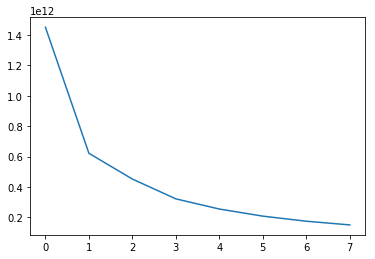

In [26]:

score_h = []
for j in range(1,9):
    score = []
    for i in range(5):
        kms = KMeans(n_clusters=j, n_jobs=10)
        score.append(kms.fit(g[i]).inertia_)
    print(sum(score))
    score_h.append(sum(score))
plt.plot(score_h)
plt.show()

It seems that we should have 2,3 centriod for each of the bucket to achieve a better score.

1
2
3
4
5
6
7
8
9


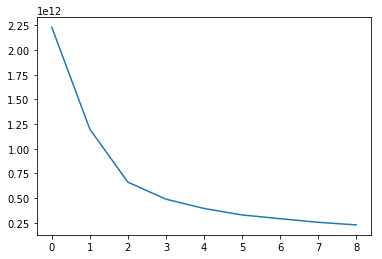

[2232054196126.829, 1199315700031.4463, 662102109991.5989, 489736264122.1579, 395590387499.6854, 329816873687.58136, 292020612557.98065, 255381714920.0169, 228769885098.27588]


In [27]:
select_tmp = solo_df.drop(['matchId', 'winPlacePerc'], axis=1)
score = []
for i in range(1,10):
    kms = KMeans(n_clusters=i, n_jobs=10)
    print(i)
    score.append(kms.fit(select_tmp).inertia_)
plt.plot(score)
plt.show()
print(score)

It seems that we should have only 2,3 centroids if we perform clustering on all of the data.

From the score of both k-means, it seems a bit wierd? At least I don't know how to explain it. This differs a lot from what I thought to be possible. Originally, I think that we might be able to find some centroids representing some populations. But it turns out that the centroids aren't able to cover the majority of the data. Also, it doesn't seems to fit well. So we won't be able to do the unsupervised trick. Finding centriod(s), explain which type of category it is most likely to fall into, create prediction. This method just don't seem to work for *k-means*.

There sure are a lot of decent techniques in clustering algorithms, such as *DBSCAN*, *Birch*... We won't get into details here. But let's try one last clustering techniques, if it fails we will go back to our original classification problem.

### DBSCAN  Density-Based Spatial Clustering of Applications with Noise
It focuses on the density within each region. If the points got dense enough, it has enough evidence to conclude that there is an cluster. Being able to form non-convex hyper-plane.

Because it will uses the distance more stricly than $k$-means, we will refactor all of the features in data to percentage points.

In [28]:

s_df = df[df['matchType'] == 'solo']

s_df = s_df.drop('DBNOs', axis=1)
s_df['winPlacePerc'] = s_df.groupby('matchId')['winPlacePerc'].rank(ascending=False)
s_df = s_df.drop(['Id', 'groupId','teamKills', 'matchType'], axis=1)

s_df = s_df.dropna(subset=['winPlacePerc'])
s_df.head()

,matchId,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,rankPoints,revives,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4,6dc8ff871e21e6,0,0,100.000,0,0,45,0,1,1,...,1560,0,0.0,0,0.00,0,49.75,2,0,79.0
7,292611730ca862,0,0,8.538,0,0,48,1000,0,0,...,-1,0,2004.0,0,0.00,0,1089.00,6,1500,26.0
13,2c30ddf481c52d,0,1,324.200,1,5,5,986,4,1,...,-1,0,1228.0,0,76.84,0,2050.00,6,1462,13.0
17,07948d723b9c0f,0,3,254.300,0,12,13,0,2,1,...,1536,0,2367.0,0,15.29,0,1787.00,3,0,18.0
35,bc2faecb77e5ec,0,0,136.900,0,0,37,0,1,1,...,1500,0,0.0,0,0.00,0,270.70,1,0,62.0


The above cell failed so many times before really being able to perform analysis.

### What about the WINNER?
![winner winner chicken dinner](https://svgbomb.com/wp-content/uploads/2018/12/free-svg-quote-svgbomb-winner-winner-chicken-dinner-696x696.jpg)

#### Play it safe stategy
There is a belief that if we try to play it safe, avoid any kinds of battle and conflicts. Whenever we get to the safe zone, we hide, instead of killing through our way.

Lets prove that to be true or not.

$H_0: \text{Playing it safe is not a strategy in the game.}$

$H_1: \text{Playing it safe exists in winner and is a somewhat dominant strategy}$

In [29]:
s_df = df[df['matchType'] == 'solo']
s_df = s_df.drop('DBNOs', axis=1)
s_df['winPlacePerc'] = s_df.groupby('matchId')['winPlacePerc'].rank(ascending=False)

change_to_percentage = ['assists','damageDealt','headshotKills', 'heals', 'killPlace', 'killPoints','killStreaks', 'longestKill', 'rankPoints', 'revives',  'roadKills', 'vehicleDestroys', 'winPoints']

s_df = s_df.drop(['Id', 'groupId','teamKills', 'matchType'], axis=1)

s_df = s_df.dropna(subset=['winPlacePerc'])

for i in s_df.columns:
#     print(i)
    if i != 'matchId' and i != 'winPlacePerc':
#     if i in change_to_percentage:
        s_df[i] = s_df.groupby('matchId')[i].rank(pct=True, axis=1)

s_df = s_df[s_df['winPlacePerc']==1]
s_df = s_df.drop(['matchId', 'winPlacePerc'], axis=1)
s_df.head()

,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
186,0.474490,0.954082,0.989796,0.994898,0.816327,0.020408,1.000000,0.989796,0.739796,0.989796,...,0.505102,0.505102,0.505102,0.459184,0.505102,0.469388,0.505102,0.918367,0.714286,0.622449
1688,0.989474,0.968421,0.926316,0.915789,0.936842,0.073684,0.505263,0.915789,0.784211,0.842105,...,0.505263,0.400000,0.505263,0.447368,0.505263,0.457895,0.505263,0.873684,0.726316,0.505263
1966,0.454545,0.797980,0.969697,0.858586,0.888889,0.040404,0.489899,0.969697,0.747475,0.848485,...,0.505051,0.505051,0.505051,0.479798,0.505051,0.469697,0.505051,0.919192,1.000000,0.767677
2372,0.968085,0.973404,0.904255,0.398936,0.382979,0.106383,0.505319,0.845745,0.723404,0.723404,...,0.505319,0.755319,0.505319,0.452128,0.505319,0.478723,0.505319,0.914894,0.776596,0.505319
2558,0.478723,0.962766,0.978723,0.882979,0.930851,0.021277,0.505319,0.978723,0.771277,0.776596,...,0.505319,0.234043,0.505319,0.957447,0.500000,0.494681,0.500000,0.893617,0.659574,0.505319


7639


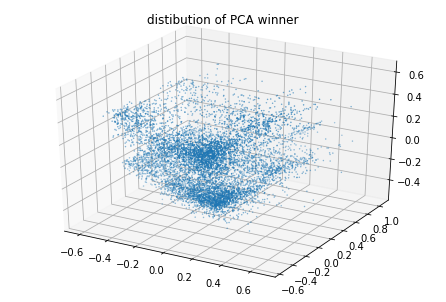

In [30]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
winner = pca.fit_transform(s_df)

x = []
y = []
z = []
fig = plt.figure()
ax = Axes3D(fig)

for i in winner:
    x.append(i[0])
    y.append(i[1])
    z.append(i[2])
print(len(x))
ax.scatter(x,y,z, s=0.2)
plt.title("distibution of PCA winner")
plt.show()

The result seems very promising, we can see that there might be two types of distribution. We might be able to segment them into two different groups and then explain it. Lets **MOVE ON**.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


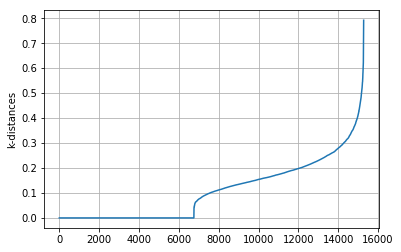

In [35]:
def k_distances2(x, k):
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    p = np.sqrt(p)
    p.sort(axis=1)
    p=p[:,:k]
    
    pm= p.flatten()
    pm= np.sort(pm)
    return p, pm
m, m2= k_distances2(np.array(s_df), 2)
plt.plot(m2)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

In [32]:
len(s_df.values)

7639

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
select_tmp = solo_df.drop(['matchId', 'winPlacePerc'], axis=1)
x = select_tmp
y_10 = solo_df['winPlacePerc']
# y_5 = solo_df['winPlacePerc']
for i in range(len(y_10)):
    r = y_10[i]
    print(r)
    y.append(int((r-1)/10))

In [ ]:
sum(solo_df['winPlacePerc'])